<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/M%C3%A8tode_expl%C3%ADcit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Partim de la EDP:


$c_vρ\frac{∂T}{∂t}=∇⋅(κ{\vec\nabla T})+P_{ext}$

Després de normalitzar i reduïr els paràmetres al mínim obtenim:

$\frac{\partial\tilde{T}}{\partial\tilde{t}}=\frac{\partial^2\tilde{T}}{\partial\tilde{x}^2}+1$



Discretitzem via Euler explícit amb la derivada per la dreta (els sub-índexs corresponen als nodes temporals, els super-índexs als nodes espaials):

$\frac{T_{i+1}^{(n)}-T_i^{(n)}}{Δt}=1+\frac{T_i^{(n+1)}-2T_i^{(n)}+T_i^{(n-1)}}{(Δx)^2}$

Aïllem $T_{i+1}^{(n)}$:

$T_{i+1}^{(n)}=Δt+\alpha T_{i}^{(n-1)}+βT_{i}^{(n)} + α T_{i}^{(n+1)}$

On: $\ α=\frac{Δt}{\Delta x^2},\ β=1-\frac{2\Delta t}{\Delta x^2}$

Això es pot escriure en forma matricial i calcular tots els punts espaials de la malla a temps $i+1$ a partir dels de $i$. Ja que tenim tots els punts de $i=0$ de les condicions de contorn

I les condicions de contorn són:

*   $T(0,x)=36,5\ ℃$
*   $\frac{\partial T(t,\ 0)}{\partial t}=\frac{\partial T(t,\ 2\ cm)}{\partial t}=0$



In [19]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import matplotlib.patches as pt

#Dades de l'enunciat

C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

N= 101   # Mallat espaial

#X i la seva normalització

x_0= 0.02
x_f= 0.02/x_0
x_i= 0

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Difusivitat càlcul

alpha_var= kappa/(C_v*rho)
#print("La difusivitat dona:", alpha_var)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#t i la seva normalització

t_i= 0
t_0= x_0**2/alpha_var
#print("t_0 és:", t_0)
t_f= 0.025
#print("t_f és:", t_f)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Càlcul de la potència externa

P_ext= volts**2*sigma/(2*(x_0)**2)
#print(P_ext)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#T i la seva discretització

T_0= P_ext/(C_v*rho)*t_0
#print("T_0 val:", T_0)
T_init= (36.5+273.15)/T_0   #Temperatura inicial en Kelvin
#print("T_init:",T_init)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

#Variacions de les variables (els tres delta t corresponen als 3 de l'enunciat)

dx= x_f/(N-1)
#print("El dx és:", dx)

dt_1= 0.51*dx**2 # disc temps 1
#print("dt_1 és:", dt_1)

dt_2= 0.49*dx**2 # disc temps 2
dt_3= 0.25*dx**2  # disc temps 3

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Bloc del càlcul amb Euler explícit:

In [20]:
#EULER CÀLCUL
def Euler_explícit (T_i, t_f, dt, dx):
  T_i= np.ones((N,1))*T_i  #Vector columna de les T_i per cada n (punt de l'espai)
  alpha = dt / (dx**2)
  beta = 1 - 2 * alpha

  #Primera columna
  col1 = np.zeros(N)
  col1[0] = beta
  if N > 1:
      col1[1] = alpha

  #Primera fila
  fila1 = np.zeros(N)
  fila1[0] = beta
  if N > 1:
      fila1[1] = alpha

  matriu = toeplitz(col1, fila1)

  #Modifiquem la matriu per tal que els termes N i 0 no variin d'acord amb les condicions de contorn
  matriu[0, :] = 0
  matriu[0, 0] = 1
  matriu[-1, :] = 0
  matriu[-1, -1] = 1

  #Creem un nou array amb els mateixos valors que a l'inici per començar a iterar
  T_iter = np.copy(T_i)
  t_i = 0

  #Vector dels dt que queden sumant
  vec_dt = np.ones((N, 1)) * dt
  vec_dt[0, 0] = 0  #Cond. de contorn
  vec_dt[-1, 0] = 0

  t = int(t_f/dt)
  for i in range(t):
    #Següent iteració
    T_iter = np.matmul(matriu, T_iter) + vec_dt

    #Ens asssegurem que això segueixi seguint les cc
    T_iter[0,0] = T_i[0,0]
    T_iter[-1,0] = T_i[-1,0]

  #Tornem a Celsius
  return T_iter * T_0 - 273.15


In [21]:
#Euler explícit: retake (experiment xungo)

def Euler_explícit2(T_i, t_f, dt, dx):
  T_i= np.array([T_i]*N)  #Vector columna de les T_i per cada n (punt de l'espai)
  alpha = dt / (dx**2)
  beta = 1 - 2 * alpha
  t_i= 0

  t = int(t_f/dt)
  for i in range(t):
      for i in range(1, len(T_i)-1):
        T_i[i]= T_i[i-1]*alpha + T_i[i+1]*alpha + T_i[i]*beta + dt

  return T_i*T_0 - 273.15

ys_2= np.squeeze(np.asarray(Euler_explícit(T_init, t_f, dt_2, dx)))
ys_2bis= Euler_explícit2(T_init, t_f, dt_2, dx)

Plots:

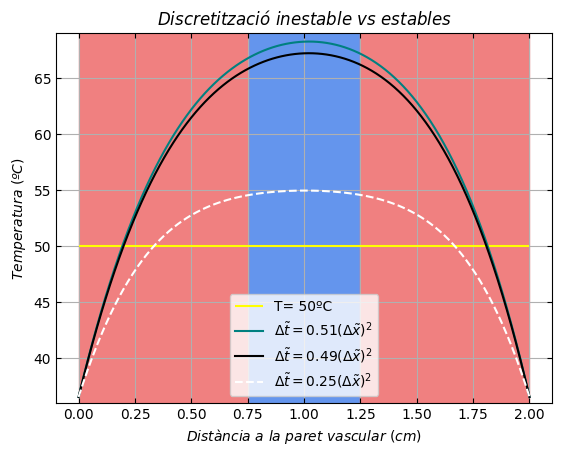

In [22]:
#Creació de la llista que farà d'eix de les x
dx_llista= np.linspace(0, 2, 101)

#Calculem per cada discretització i ho guardem a una variable
ys_1= Euler_explícit2(T_init, t_f, dt_1, dx)
ys_2= Euler_explícit2(T_init, t_f, dt_2, dx)
ys_3= Euler_explícit2(T_init, t_f, 0.10*(dx)**2, dx)

fig, ax= plt.subplots()

lim_inf_y= float(np.floor(np.min(ys_1)))
altura= float(np.floor(np.max(ys_1)+1)-np.floor(np.min(ys_1)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=1)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title(r"$Discretització\ inestable\ vs\ estables$")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Temperatura\ (ºC)$")


plt.ylim(lim_inf_y, np.floor(np.max(ys_1)+1))
plt.hlines(50, 0, 2, color="yellow", label="T= 50ºC")

plt.plot(dx_llista, ys_1, color="teal", label=r"$\Delta \tilde{t}= 0.51(\Delta \tilde{x})^2$")
plt.plot(dx_llista, ys_2, color="k", label=r"$\Delta \tilde{t}= 0.49(\Delta \tilde{x})^2$")
plt.plot(dx_llista, ys_3, color="white", label=r"$\Delta \tilde{t}= 0.25(\Delta \tilde{x})^2$", linestyle="--")
plt.legend()
plt.grid("equal")
plt.tick_params(direction="in", top=True, right=True)
plt.show()

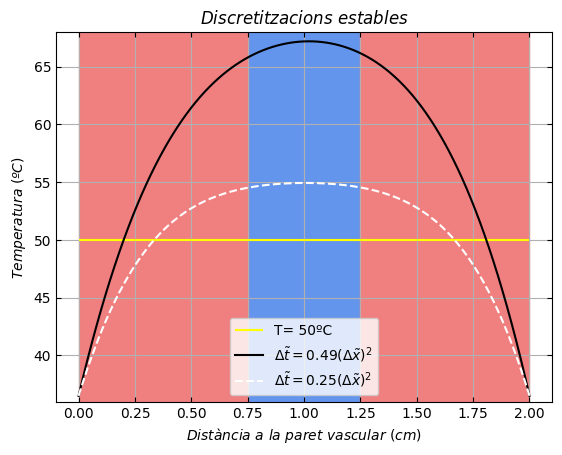

In [23]:
from matplotlib.lines import lineStyles
fig, ax= plt.subplots()

lim_inf_y= float(np.floor(np.min(ys_2)))
altura= float(np.floor(np.max(ys_2)+1)-np.floor(np.min(ys_2)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=1)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title(r"$Discretitzacions\ estables$")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Temperatura\ (ºC)$")

plt.ylim(lim_inf_y, np.floor(np.max(ys_2)+1))
plt.hlines(50, 0, 2, color="yellow", label="T= 50ºC")

plt.plot(dx_llista, ys_2, color="k", label=r"$\Delta \tilde{t}= 0.49(\Delta \tilde{x})^2$")
plt.plot(dx_llista, ys_3, color="white", label=r"$\Delta \tilde{t}= 0.25(\Delta \tilde{x})^2$", linestyle="--")
plt.legend()
plt.grid("equal")
plt.tick_params(direction="in", top=True, right=True)
plt.show()

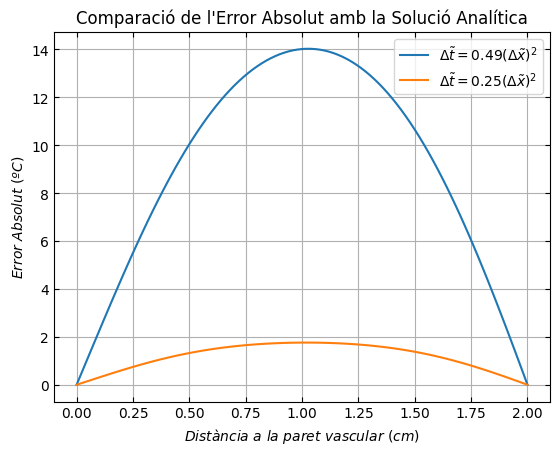

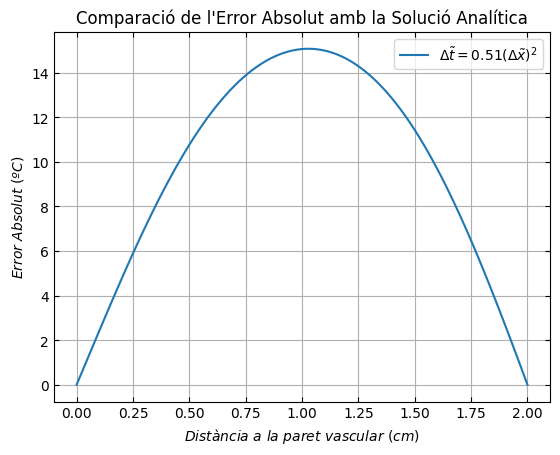

In [24]:
import numpy as np
import matplotlib.pyplot as plt

#COMPARACIÓ AMB LA SOLUCIÓ ANALÍTICA

T_real_analitica = np.array([36.5, 37.66969108, 38.77435843, 39.81640155, 40.79821064, 41.72216161,
 42.59061136, 43.40589333, 44.17031304, 44.88614393, 45.55562325, 46.18094826,
 46.76427258, 47.30770281, 47.81329543, 48.28305392, 48.71892617, 49.12280218,
 49.49651205, 49.84182427, 50.16044422, 50.45401308, 50.72410691, 50.97223607,
 51.19984485, 51.40831139, 51.59894779, 51.77300053, 51.93165095, 52.07601607,
 52.20714947, 52.32604233, 52.43362469, 52.53076667, 52.61827989, 52.69691893,
 52.76738279, 52.83031642, 52.88631225, 52.93591169, 52.97960659, 53.01784069,
 53.05101097, 53.07946891, 53.10352169, 53.12343327, 53.13942529, 53.15167798,
 53.16033077, 53.16548287, 53.16719365, 53.16548287, 53.16033077, 53.15167798,
 53.13942529, 53.12343327, 53.10352169, 53.07946891, 53.05101097, 53.01784069,
 52.97960659, 52.93591169, 52.88631225, 52.83031642, 52.76738279, 52.69691893,
 52.61827989, 52.53076667, 52.43362469, 52.32604233, 52.20714947, 52.07601607,
 51.93165095, 51.77300053, 51.59894779, 51.40831139, 51.19984485, 50.97223607,
 50.72410691, 50.45401308, 50.16044422, 49.84182427, 49.49651205, 49.12280218,
 48.71892617, 48.28305392, 47.81329543, 47.30770281, 46.76427258, 46.18094826,
 45.55562325, 44.88614393, 44.17031304, 43.40589333, 42.59061136, 41.72216161,
 40.79821064, 39.81640155, 38.77435843, 37.66969108, 36.5])
 # Solució analítica en ºC prèviament calculada

ys_1= np.squeeze(np.asarray(ys_1))  #Ho passem de matriu a array per poder restar-li la solució analítica
ys_2= np.squeeze(np.asarray(ys_2))
ys_3= np.squeeze(np.asarray(ys_3))

plt.figure()
plt.plot(dx_llista, np.abs(np.array(ys_2)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.49(\Delta\tilde{x})^2$")
plt.plot(dx_llista, np.abs(np.array(ys_3)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.25(\Delta\tilde{x})^2$")

plt.title("Comparació de l'Error Absolut amb la Solució Analítica")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Error\ Absolut\ (ºC)$")
plt.legend()
plt.tick_params(direction="in", top=True, right=True)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(dx_llista, np.abs(np.array(ys_1)-T_real_analitica), label=r"$\Delta\tilde{t}= 0.51(\Delta\tilde{x})^2$")
plt.title("Comparació de l'Error Absolut amb la Solució Analítica")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Error\ Absolut\ (ºC)$")
plt.legend()
plt.tick_params(direction="in", top=True, right=True)
plt.grid(True)
plt.show()